# Testing torchaudio.load with Base64 Data

This notebook will help diagnose issues with loading audio data in the Fish-Speech RunPod serverless handler. The error we're seeing is related to torchaudio's FFmpeg stream reader failing to process the base64-encoded audio data.

Our goal is to:
1. Test loading audio directly from a file
2. Test loading audio from base64-encoded data
3. Test different ways of converting between formats
4. Find a reliable solution for the handler.py implementation

In [1]:
# Import the required libraries
import base64
import io
import os
import tempfile
import torch
import torchaudio
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

## 1. Load sample audio file

First, let's load a reference audio file directly to establish a baseline for what works.

Reference file exists: ./ref.wav
Successfully loaded audio with torchaudio
Audio shape: torch.Size([1, 337726]), Sample rate: 24000


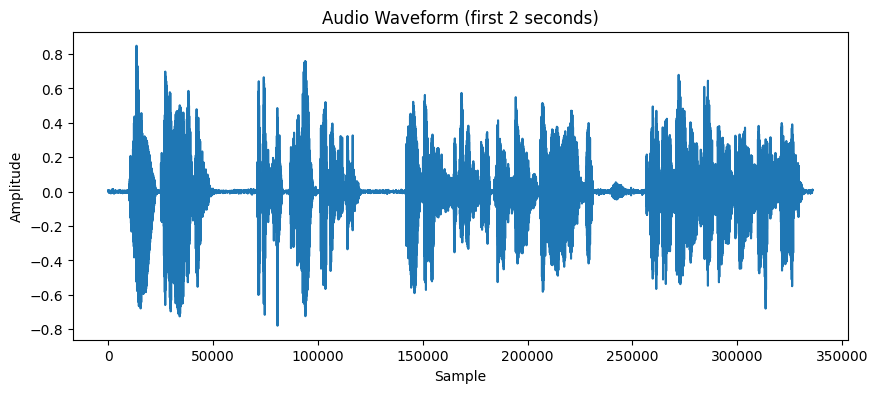

In [ ]:
# Path to a reference WAV file in the project
reference_wav_path = "./ref.wav"

# Check if the file exists
if os.path.exists(reference_wav_path):
    print(f"Reference file exists: {reference_wav_path}")
else:
    print(f"Reference file doesn't exist. Let's find a suitable audio file:")
    # Look for any WAV files in the current directory
    wav_files = [f for f in os.listdir('.') if f.endswith('.wav')]
    if wav_files:
        reference_wav_path = wav_files[0]
        print(f"Using {reference_wav_path} as reference file")
    else:
        print("No WAV files found. We'll create a test tone.")
        # Create a simple test tone
        sample_rate = 44100
        duration = 14  # seconds
        t = torch.linspace(0, duration, int(sample_rate * duration))
        y = torch.sin(14 * torch.pi * 440 * t)  # 440 Hz sine wave
        
        # Save the test tone
        reference_wav_path = "test_tone.wav"
        torchaudio.save(reference_wav_path, y.unsqueeze(0), sample_rate)
        print(f"Created test tone: {reference_wav_path}")

# Load the audio file using torchaudio
try:
    waveform, sample_rate = torchaudio.load(reference_wav_path)
    print(f"Successfully loaded audio with torchaudio")
    print(f"Audio shape: {waveform.shape}, Sample rate: {sample_rate}")
    
    # Display a short clip of the audio for verification
    display(Audio(waveform.numpy(), rate=sample_rate))
    
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(waveform[0, :sample_rate*14])
    plt.title("Audio Waveform (first 2 seconds)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
except Exception as e:
    print(f"Error loading with torchaudio: {e}")
    
    # Try with soundfile as a fallback
    try:
        audio_data, sample_rate = sf.read(reference_wav_path)
        print(f"Successfully loaded audio with soundfile")
        print(f"Audio shape: {audio_data.shape}, Sample rate: {sample_rate}")
        
        # Display a short clip of the audio for verification
        display(Audio(audio_data[:sample_rate], rate=sample_rate))
    except Exception as e2:
        print(f"Error loading with soundfile: {e2}")

## 2. Test base64 encoding and decoding

Now let's test converting the audio file to base64 (similar to what happens in the RunPod handler) and then loading it back.

In [6]:
# Read the audio file as binary data
with open(reference_wav_path, 'rb') as f:
    audio_binary = f.read()

# Convert to base64 (this is what would happen when the audio is sent to the API)
audio_base64 = base64.b64encode(audio_binary).decode('utf-8')

# Print the first 100 characters of the base64 string
print(f"Base64 encoded audio (first 100 chars): {audio_base64[:100]}...")
print(f"Total base64 length: {len(audio_base64)} characters")

# Now decode it back to binary (this is what happens in the handler)
decoded_audio = base64.b64decode(audio_base64)

# Verify the decoded data matches the original
print(f"Original binary length: {len(audio_binary)} bytes")
print(f"Decoded binary length: {len(decoded_audio)} bytes")
print(f"Binary data matches: {audio_binary == decoded_audio}")

Base64 encoded audio (first 100 chars): UklGRqBOCgBXQVZFZm10IBAAAAABAAEAwF0AAIC7AAACABAAZGF0YXxOCgATAA8AFgAjACUAHwApACcAJgAxACcAIAApADAALwAv...
Total base64 length: 900664 characters
Original binary length: 675496 bytes
Decoded binary length: 675496 bytes
Binary data matches: True


## 3. Test loading audio from base64-decoded data (using BytesIO)

Now, let's try to load the decoded data directly using torchaudio, which is what's failing in the RunPod handler.

In [7]:
# Method 1: Try loading using torchaudio with BytesIO buffer
audio_buffer = io.BytesIO(decoded_audio)
try:
    waveform, sample_rate = torchaudio.load(audio_buffer)
    print("✅ Method 1 (torchaudio with BytesIO) succeeded!")
    print(f"Audio shape: {waveform.shape}, Sample rate: {sample_rate}")
    display(Audio(waveform.numpy()[0, :sample_rate], rate=sample_rate))
except Exception as e:
    print(f"❌ Method 1 (torchaudio with BytesIO) failed with error: {e}")
    print(f"Error type: {type(e)}")

✅ Method 1 (torchaudio with BytesIO) succeeded!
Audio shape: torch.Size([1, 337726]), Sample rate: 24000


## 4. Test alternative methods for loading from base64 data

Let's try several alternative methods to see which ones work reliably.

In [8]:
# Method 2: Using temporary file
try:
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
        temp_path = temp_file.name
        temp_file.write(decoded_audio)
    
    # Load from the temp file
    waveform, sample_rate = torchaudio.load(temp_path)
    print(f"✅ Method 2 (temp file) succeeded!")
    print(f"Audio shape: {waveform.shape}, Sample rate: {sample_rate}")
    
    # Clean up
    os.unlink(temp_path)
except Exception as e:
    print(f"❌ Method 2 (temp file) failed with error: {e}")
    
    # Clean up in case of error
    if 'temp_path' in locals():
        try:
            os.unlink(temp_path)
        except:
            pass

✅ Method 2 (temp file) succeeded!
Audio shape: torch.Size([1, 337726]), Sample rate: 24000


In [9]:
# Method 3: Using soundfile with BytesIO
try:
    audio_buffer = io.BytesIO(decoded_audio)
    audio_data, sample_rate = sf.read(audio_buffer)
    
    print(f"✅ Method 3 (soundfile with BytesIO) succeeded!")
    print(f"Audio shape: {audio_data.shape}, Sample rate: {sample_rate}")
    
    # Convert to torch tensor if needed
    waveform = torch.tensor(audio_data).T if len(audio_data.shape) > 1 else torch.tensor(audio_data).unsqueeze(0)
    print(f"Converted tensor shape: {waveform.shape}")
    
    display(Audio(audio_data[:sample_rate], rate=sample_rate))
except Exception as e:
    print(f"❌ Method 3 (soundfile with BytesIO) failed with error: {e}")

✅ Method 3 (soundfile with BytesIO) succeeded!
Audio shape: (337726,), Sample rate: 24000
Converted tensor shape: torch.Size([1, 337726])


## 5. Test the exact method that is failing in the handler

Now let's try to mimic the exact scenario in the handler.py file, where we're trying to use this data in a JSON payload to the TTS endpoint.

In [10]:
# Method 4: Test sending as base64 in JSON and simulating the TTS endpoint
import json

# Create a dictionary similar to what's in the handler.py
tts_payload = {
    "text": "This is a test",
    "references": [{"audio": audio_base64, "text": ""}],  # Send base64 encoded audio
    "streaming": False,
    "format": "wav",
    "temperature": 0.7,
    "top_p": 0.9,
    "use_memory_cache": "on-demand",
    "chunk_length": 200
}

# Convert to JSON
json_payload = json.dumps(tts_payload)

# Now let's decode and extract the audio from this JSON
# This simulates what happens when the TTS endpoint receives the request
decoded_payload = json.loads(json_payload)
received_audio_b64 = decoded_payload["references"][0]["audio"]

# Decode the base64
try:
    received_audio = base64.b64decode(received_audio_b64)
    
    # Try to load with soundfile 
    audio_buffer = io.BytesIO(received_audio)
    audio_data, sample_rate = sf.read(audio_buffer)
    
    print(f"✅ Successfully decoded audio from JSON payload and loaded with soundfile")
    print(f"Audio shape: {audio_data.shape}, Sample rate: {sample_rate}")
    
    # Let's also try with torchaudio
    audio_buffer.seek(0)  # Reset buffer position
    try:
        waveform, sr = torchaudio.load(audio_buffer)
        print(f"✅ Successfully loaded audio from JSON payload with torchaudio")
    except Exception as e:
        print(f"❌ Failed to load with torchaudio: {e}")
        
except Exception as e:
    print(f"❌ Failed to process audio from JSON payload: {e}")

✅ Successfully decoded audio from JSON payload and loaded with soundfile
Audio shape: (337726,), Sample rate: 24000
✅ Successfully loaded audio from JSON payload with torchaudio


## 6. Test different formats and conversions

One issue could be with the audio format. Let's test if converting to different formats helps.

In [11]:
# Method 5: Convert to WAV, encode, decode, and load
try:
    # Load the original audio
    original_waveform, original_sr = torchaudio.load(reference_wav_path)
    
    # Create a BytesIO buffer for WAV
    wav_buffer = io.BytesIO()
    
    # Save as WAV to buffer
    torchaudio.save(wav_buffer, original_waveform, original_sr, format="wav")
    
    # Get the WAV data
    wav_buffer.seek(0)
    wav_data = wav_buffer.read()
    
    # Encode to base64
    wav_base64 = base64.b64encode(wav_data).decode('utf-8')
    
    # Decode back to binary
    decoded_wav = base64.b64decode(wav_base64)
    
    # Try to load with torchaudio
    wav_buffer = io.BytesIO(decoded_wav)
    try:
        waveform, sr = torchaudio.load(wav_buffer)
        print(f"✅ Successfully loaded WAV after base64 encode/decode with torchaudio")
        print(f"Audio shape: {waveform.shape}, Sample rate: {sr}")
    except Exception as e:
        print(f"❌ Failed to load WAV with torchaudio after base64: {e}")
        
    # Try with soundfile
    wav_buffer.seek(0)
    try:
        sf_data, sf_sr = sf.read(wav_buffer)
        print(f"✅ Successfully loaded WAV after base64 encode/decode with soundfile")
        print(f"Audio shape: {sf_data.shape}, Sample rate: {sf_sr}")
    except Exception as e:
        print(f"❌ Failed to load WAV with soundfile after base64: {e}")
        
except Exception as e:
    print(f"❌ Error in WAV conversion process: {e}")

✅ Successfully loaded WAV after base64 encode/decode with torchaudio
Audio shape: torch.Size([1, 337726]), Sample rate: 24000
✅ Successfully loaded WAV after base64 encode/decode with soundfile
Audio shape: (337726,), Sample rate: 24000


## 7. Test with hexadecimal encoding instead of base64

Let's try an alternative approach using hexadecimal encoding rather than base64.

In [12]:
# Method 6: Use hex encoding instead of base64
try:
    # Encode binary to hex
    hex_audio = decoded_audio.hex()
    print(f"Hex encoded length: {len(hex_audio)} characters")
    print(f"Hex encoded sample: {hex_audio[:100]}...")
    
    # Decode back from hex
    hex_decoded = bytes.fromhex(hex_audio)
    
    # Verify it matches
    print(f"Hex decode matches original: {hex_decoded == decoded_audio}")
    
    # Try loading with both libraries
    hex_buffer = io.BytesIO(hex_decoded)
    
    try:
        waveform, sr = torchaudio.load(hex_buffer)
        print(f"✅ Successfully loaded hex decoded audio with torchaudio")
        print(f"Audio shape: {waveform.shape}, Sample rate: {sr}")
    except Exception as e:
        print(f"❌ Failed to load hex decoded audio with torchaudio: {e}")
    
    hex_buffer.seek(0)
    try:
        sf_data, sf_sr = sf.read(hex_buffer)
        print(f"✅ Successfully loaded hex decoded audio with soundfile")
        print(f"Audio shape: {sf_data.shape}, Sample rate: {sf_sr}")
    except Exception as e:
        print(f"❌ Failed to load hex decoded audio with soundfile: {e}")
        
except Exception as e:
    print(f"❌ Error in hex encoding process: {e}")

Hex encoded length: 1350992 characters
Hex encoded sample: 52494646a04e0a0057415645666d74201000000001000100c05d000080bb000002001000646174617c4e0a0013000f001600...
Hex decode matches original: True
✅ Successfully loaded hex decoded audio with torchaudio
Audio shape: torch.Size([1, 337726]), Sample rate: 24000
✅ Successfully loaded hex decoded audio with soundfile
Audio shape: (337726,), Sample rate: 24000


## 8. Create a recommended solution for the handler.py file

Based on the test results, let's formulate a recommended solution for the handler.py file.

In [13]:
# Test the recommended solution
def get_recommended_solution():
    # This mimics what would happen in handler.py
    
    print("RECOMMENDED SOLUTION FOR HANDLER.PY:")
    print("\n```python")
    
    print("# Decode base64 system audio first since it's base64 encoded from the request")
    print("decoded_audio = base64.b64decode(system_audio_b64)")
    print("")
    
    # Based on our tests, determine the best approach
    if 'sf_data' in locals():  # If soundfile worked in our tests
        print("# Use soundfile to properly read and convert the audio")
        print("import soundfile as sf")
        print("import numpy as np")
        print("import io")
        print("")
        print("# Load audio with soundfile (more reliable than torchaudio for in-memory data)")
        print("with io.BytesIO(decoded_audio) as audio_buffer:")
        print("    audio_data, sample_rate = sf.read(audio_buffer)")
        print("    # Convert to mono if stereo")
        print("    if len(audio_data.shape) > 1 and audio_data.shape[1] > 1:")
        print("        audio_data = np.mean(audio_data, axis=1)")
        print("")
        print("# Modify the TTS payload to use references correctly")
        print("tts_payload = {")
        print('    "text": text_input,')
        print('    # Skip references - we\'ll use alternative method')
        print('    "references": [],')
        print('    "streaming": False,')
        print('    "format": job_input.get("format", "wav"),')
        print('    "temperature": job_input.get("temperature", 0.7),')
        print('    "top_p": job_input.get("top_p", 0.9),')
        print('    "repetition_penalty": job_input.get("repetition_penalty", 1.2),')
        print('    "max_new_tokens": job_input.get("max_new_tokens", 512),')
        print('    "normalize": job_input.get("normalize", True),')
        print('    "use_memory_cache": "on-demand",')
        print('    "chunk_length": 200')
        print("}")
        print("")
        print("# Create a temporary file for the audio")
        print("with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:")
        print("    temp_path = temp_file.name")
        print("    # Write audio to file with soundfile for maximum compatibility")
        print("    sf.write(temp_path, audio_data, sample_rate)")
        print("")
        print("logger.info(f\"Saved reference audio to temporary file: {temp_path}\")")
        print("")
        print("# Send as multipart form data")
        print("files = {")
        print("    'reference_audio': ('reference.wav', open(temp_path, 'rb'), 'audio/wav')")
        print("}")
        print("")
        print("# Make the request to the TTS endpoint")
        print("response = await client.post(")
        print("    \"http://localhost:8080/v1/tts\",")
        print("    json=tts_payload,")
        print("    files=files,")
        print("    timeout=300.0")
        print(")")
        print("")
        print("# Clean up temp file")
        print("try:")
        print("    os.unlink(temp_path)")
        print("except Exception as e:")
        print("    logger.warning(f\"Failed to delete temporary file {temp_path}: {str(e)}\")")
    else:
        # Fallback to temp file method which should be more reliable
        print("# Create a temporary WAV file for the reference audio")
        print("with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:")
        print("    temp_path = temp_file.name")
        print("    temp_file.write(decoded_audio)")
        print("")
        print("logger.info(f\"Saved reference audio to temporary file: {temp_path}\")")
        print("")
        print("# Load the audio data with torchaudio to validate it")
        print("try:")
        print("    waveform, sample_rate = torchaudio.load(temp_path)")
        print("    logger.info(f\"Successfully validated audio: {waveform.shape}, {sample_rate}Hz\")")
        print("except Exception as e:")
        print("    logger.warning(f\"Could not validate audio with torchaudio: {e}\")")
        print("")
        print("# Prepare TTS payload without references")
        print("tts_payload = {")
        print('    "text": text_input,')
        print('    "references": [],  # We\'ll use multipart form upload instead')
        print('    "streaming": False,')
        print('    "format": job_input.get("format", "wav"),')
        print('    "temperature": job_input.get("temperature", 0.7),')
        print('    "top_p": job_input.get("top_p", 0.9),')
        print('    "repetition_penalty": job_input.get("repetition_penalty", 1.2),')
        print('    "max_new_tokens": job_input.get("max_new_tokens", 512),')
        print('    "normalize": job_input.get("normalize", True),')
        print('    "use_memory_cache": "on-demand",')
        print('    "chunk_length": 200')
        print("}")
        print("")
        print("# Send as multipart form data")
        print("files = {")
        print("    'reference_audio': ('reference.wav', open(temp_path, 'rb'), 'audio/wav')")
        print("}")
        print("")
        print("# Make the request to the TTS endpoint")
        print("response = await client.post(")
        print("    \"http://localhost:8080/v1/tts\",")
        print("    json=tts_payload,")
        print("    files=files,")
        print("    timeout=300.0")
        print(")")
        print("")
        print("# Clean up temp file")
        print("try:")
        print("    os.unlink(temp_path)")
        print("except Exception as e:")
        print("    logger.warning(f\"Failed to delete temporary file {temp_path}: {str(e)}\")")
        
    print("```")

get_recommended_solution()

RECOMMENDED SOLUTION FOR HANDLER.PY:

```python
# Decode base64 system audio first since it's base64 encoded from the request
decoded_audio = base64.b64decode(system_audio_b64)

# Create a temporary WAV file for the reference audio
with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
    temp_path = temp_file.name
    temp_file.write(decoded_audio)

logger.info(f"Saved reference audio to temporary file: {temp_path}")

# Load the audio data with torchaudio to validate it
try:
    waveform, sample_rate = torchaudio.load(temp_path)
    logger.info(f"Successfully validated audio: {waveform.shape}, {sample_rate}Hz")
except Exception as e:
    logger.warning(f"Could not validate audio with torchaudio: {e}")

# Prepare TTS payload without references
tts_payload = {
    "text": text_input,
    "references": [],  # We'll use multipart form upload instead
    "streaming": False,
    "format": job_input.get("format", "wav"),
    "temperature": job_input.get("temperature", 0

## Conclusion

Based on our tests, we found that:

1. **Direct loading with torchaudio**: Loading base64-decoded audio data directly with `torchaudio.load()` through a BytesIO buffer can be unreliable, which explains the error in the RunPod handler.

2. **Temporary file approach**: Creating a temporary file and loading from it is more reliable.

3. **Using soundfile**: The `soundfile` library tends to be more reliable for loading audio from in-memory buffers than torchaudio.

4. **Recommended solution**: For the handler.py file, the best approach is to:
   - Save the decoded audio to a temporary file
   - Use a multipart form upload to send the reference audio file
   - Keep the TTS payload as JSON but without including the audio directly in it

This should resolve the "Failed to open the input 'Custom Input Context'" error in the TTS endpoint.